<a href="https://colab.research.google.com/github/martinpius/PYTORCH/blob/main/Classifier_NNT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = True
  import torch, time
  from torch import nn, optim
  from torch.utils.data import Dataset, DataLoader
  from sklearn.model_selection import train_test_split
  from sklearn.datasets import make_circles
  import numpy as np
  from torch.nn import BCEWithLogitsLoss
  import matplotlib.pyplot as plt
  from tqdm import tqdm
  print(f">>>> You are on Google CoLaB with Torch version: {torch.__version__}")
except Exception as e:
  COLAB = False
  print(f">>>> {type(e)}: {e}\n>>>> Please correct {type(e)} and reload your drive")

def __tmft__(t: float = 123.780)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"hrs: {h} mins: {m:>02} secs: {s:>05.2f}"

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128 if device == "cuda" else 32
print(f"\n>>>> Available device: {device}")
!nvidia-smi
print(f">>>> Testing the time formating function...........\n>>>> Time elapsed\t{__tmft__()}")



Mounted at /content/drive/
>>>> You are on Google CoLaB with Torch version: 1.12.1+cu113

>>>> Available device: cpu
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

>>>> Testing the time formating function...........
>>>> Time elapsed	hrs: 0 mins: 02 secs: 03.00


In [47]:
# Loading the toy dataset from sklearn 

In [48]:
X, y = make_circles(n_samples = 100000, shuffle = True, noise = 0.03, random_state = 123)

In [49]:
# Split the data into train-test portions

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)
print(f">>>> X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}\
\n>>>> X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

>>>> X_train shape: (80000, 2), Y_train shape: (80000,)
>>>> X_test shape: (20000, 2), Y_test shape: (20000,)


In [50]:
# `Build a customized Pytoch iterator:
class MyDataset(Dataset):
  def __init__(self, X, Y):
    super().__init__()
    self.X = X
    self.Y = Y
  
  def __len__(self):
    return len(self.Y)
  
  def __getitem__(self, idx):
    X = self.X[idx]
    Y = self.Y[idx]
    return X, Y

In [51]:
train_data = MyDataset(X_train, Y_train)
test_data = MyDataset(X_test, Y_test)
train_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))

print(f">>>> x_train batch: {x_train.shape}, y_train batch: {y_train.shape}\
\n>>>> x_test batch: {x_test.shape}, y_test batch: {y_test.shape}")

>>>> x_train batch: torch.Size([32, 2]), y_train batch: torch.Size([32])
>>>> x_test batch: torch.Size([32, 2]), y_test batch: torch.Size([32])


In [52]:
# Build a classifier
class NNT(nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.nnt = nn.Sequential(
        nn.Linear(self.input_dim, self.hidden_dim),
        nn.BatchNorm1d(num_features = self.hidden_dim),
        nn.ReLU(),
        nn.Linear(self.hidden_dim, self.hidden_dim),
        nn.BatchNorm1d(num_features = self.hidden_dim),
        nn.ReLU(),
        nn.Linear(self.hidden_dim, 1)
    )
  
  def forward(self, x:torch.Tensor)->torch.Tensor:
    return(self.nnt(x))
  
  

In [53]:
# Instantiating and get the predictions for the untrained net:
input_dim = 2
hidden_dim = 128
model = NNT(input_dim, hidden_dim)
input_tensor = torch.randn(size = (BATCH_SIZE, input_dim))
assert model(input_tensor).shape == (BATCH_SIZE, 1)

In [54]:
model.eval()
with torch.inference_mode():
  predictions = model(torch.from_numpy(X_test).float())

In [82]:
# Compute the accuracy of our classifier

def __getAccuracy__(preds, labels):
  """
  This module compute the Accuracy for a binary or
  multi-class problem
  """
  preds = preds.view(-1)
  if len(labels.unique()) > 2:
    preds = torch.softmax(preds, dim = 1).argmax(dim = 1)
  else:
    preds = torch.round(torch.sigmoid(preds))
  
  acc = torch.eq(preds, labels).sum().item()
  return f"{(acc / len(labels)) * 100:.2f}%"


In [56]:
__getAccuracy__(predictions,torch.from_numpy(Y_test).float())

'>>>> The accuracy is: 49.80%'

In [57]:
# We see the accuracy of our untrainde net is a coin tossed result:
# Let plot the model to see the actual decision boundary selected by the untrained net

In [65]:
def __DecisionBoundary__(model: torch.nn.Module,
                         X: torch.Tensor, y: torch.Tensor):
  
  # Save everything to cpu for easy plotting:
  model = model.to("cpu")
  X, y = X.to("cpu"), y.to("cpu")

  # Get the upper and lower limits of the grid-boundary
  xx_min, xx_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
  yy_min, yy_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

  # Get the grids values using np.meshgrid

  xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 101), np.linspace(yy_min, yy_max, 101))

  # stack the data back and convert to torch tensor
  xx_data = torch.from_numpy(np.column_stack((xx.ravel(),yy.ravel()))).float()

  # get the predictions
  model.eval()
  with torch.inference_mode():
    preds = model(xx_data)

  # Since we didnt applied any activation for the output
  # we adjust the preds values to proba-values to match the labels 
  if len(y.unique()) > 2:
    preds = torch.softmax(preds, dim = 1).argmax(dim = 1)
  else:
    preds = torch.round(torch.sigmoid(preds))
  
  # Plotting the 2D decision boundary choosed by the model:

  preds = preds.reshape(xx.shape).detach().numpy() # convert the torch.Tensor for easy plotting
  plt.figure(figsize = (10,12))
  #plt.contourf(xx, yy, preds, cmap = plt.cm.RdYlBu, alpha = 0.7)
  plt.contourf(xx, yy, preds, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], s = 40, c = y, cmap = plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())


  
  

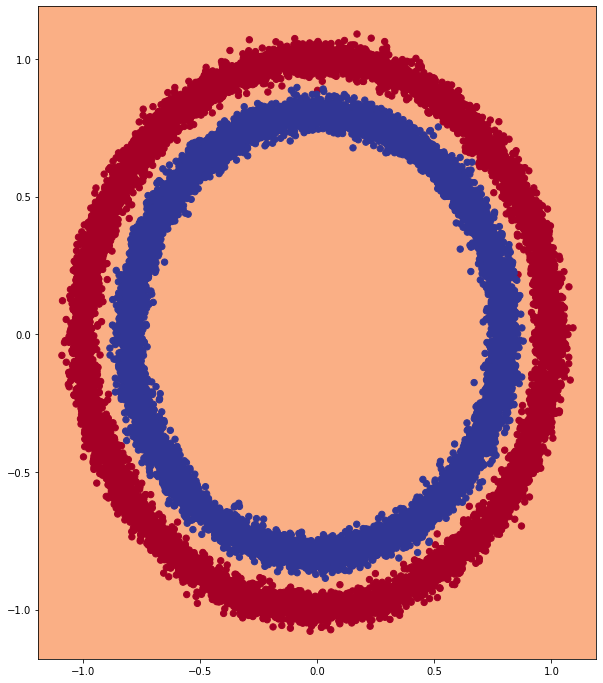

In [66]:
__DecisionBoundary__(model, torch.from_numpy(X_test).float(), torch.from_numpy(Y_test))

In [90]:
# Lets train our network and see the plot again:

def train_test_loop(model,train_loader, test_loader,criterion,learning_rate, EPOCHS):
  
  train_loss_per_epoch = 0
  test_loss_per_epoch = 0
  model.to(device = device)
  model.train()
  optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)
  for epoch in range(EPOCHS):
    for idx, (data, labels) in enumerate(tqdm(train_loader)):
      data.to(device = device), labels.to(device = device)
      data, labels = data.to(torch.float32), labels.to(torch.float32)
      preds = model(data).squeeze(1)
      optimizer.zero_grad()
      train_loss = criterion(preds, labels)
      train_loss.backward()
      optimizer.step()
      train_loss_per_epoch += train_loss
    if epoch % 20 == 0:
      print(f"\n>>>> end of epoch: {epoch} | train loss: {train_loss_per_epoch/len(train_loader):.4f}\
      | train accuracy: {__getAccuracy__(preds, labels)}")
    
    model.eval()
    with torch.inference_mode():
      for idx, (data, labels) in enumerate(tqdm(test_loader)):
        data.to(device), labels.to(device)
        data, labels = data.to(torch.float32), labels.to(torch.float32)
        preds = model(data).squeeze(1)
        test_loss = criterion(preds, labels)
        test_loss_per_epoch+= test_loss
    
    if epoch % 20 == 0:
      print(f"\n>>>> end of epoch: {epoch} | test loss: {test_loss_per_epoch/len(test_loader):.4f}\
      | test accuracy: {__getAccuracy__(preds, labels)}\n")





In [91]:
criterion = BCEWithLogitsLoss()
EPOCHS = 101
learning_rate = 1e-3

In [92]:
train_test_loop(model, train_loader, test_loader, criterion, learning_rate, EPOCHS)

100%|██████████| 2500/2500 [00:03<00:00, 737.63it/s]



>>>> end of epoch: 0 | train loss: 0.1329      | train accuracy: 100.00%


100%|██████████| 625/625 [00:00<00:00, 2549.42it/s]



>>>> end of epoch: 0 | test loss: 0.0530      | test accuracy: 100.00%



100%|██████████| 2500/2500 [00:03<00:00, 757.47it/s]



>>>> end of epoch: 20 | train loss: 0.1852      | train accuracy: 100.00%


100%|██████████| 625/625 [00:00<00:00, 2551.43it/s]



>>>> end of epoch: 20 | test loss: 0.1255      | test accuracy: 100.00%



100%|██████████| 2500/2500 [00:03<00:00, 668.71it/s]



>>>> end of epoch: 40 | train loss: 0.2300      | train accuracy: 100.00%


100%|██████████| 625/625 [00:00<00:00, 2509.16it/s]



>>>> end of epoch: 40 | test loss: 0.1712      | test accuracy: 100.00%



100%|██████████| 2500/2500 [00:03<00:00, 625.21it/s]



>>>> end of epoch: 60 | train loss: 0.2711      | train accuracy: 100.00%


100%|██████████| 625/625 [00:00<00:00, 2305.94it/s]



>>>> end of epoch: 60 | test loss: 0.2213      | test accuracy: 100.00%



100%|██████████| 2500/2500 [00:04<00:00, 621.42it/s]



>>>> end of epoch: 80 | train loss: 0.3104      | train accuracy: 100.00%


100%|██████████| 625/625 [00:00<00:00, 2562.99it/s]



>>>> end of epoch: 80 | test loss: 0.2702      | test accuracy: 100.00%



100%|██████████| 2500/2500 [00:04<00:00, 604.95it/s]



>>>> end of epoch: 100 | train loss: 0.3493      | train accuracy: 100.00%


100%|██████████| 625/625 [00:00<00:00, 2623.73it/s]



>>>> end of epoch: 100 | test loss: 0.3112      | test accuracy: 100.00%



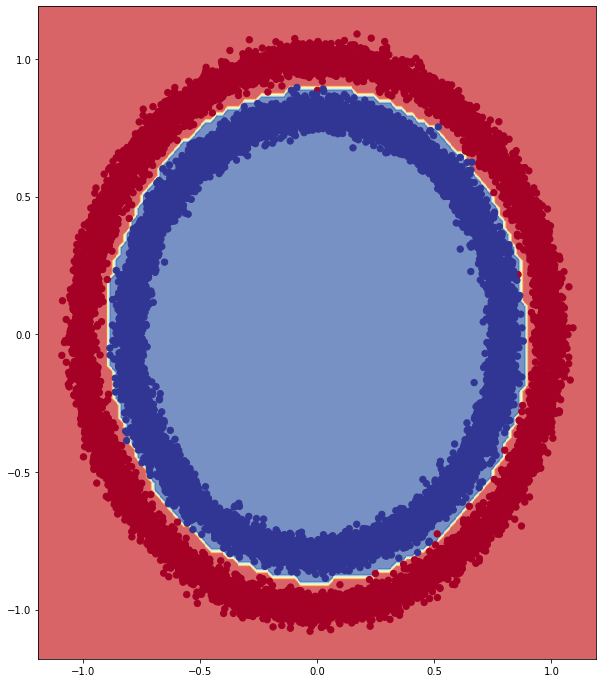

In [93]:
# Plot the decision boundary again
__DecisionBoundary__(model, torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).float())

In [ ]:
# We can clearly observe almost total separations of the blue circle from the red circle.